In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.12.0


In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('AirPassengers.csv', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [26]:
df

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

In [27]:
mean = df.mean()
print(mean)

Passengers    280.298611
dtype: float64


In [28]:
series = np.array(df.Passengers)

In [29]:
time = np.arange(len(series))

In [30]:
split_time = 120
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [31]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 90

In [32]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

слои Lambda могут быть удобны для простых вычислений без сохранения состояния

RNN - рекуррентная нейронная сеть (Трудность рекуррентной сети заключается в том, что если учитывать каждый шаг времени, то становится необходимым для каждого шага времени создавать свой слой нейронов, что вызывает серьёзные вычислительные сложности.)

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=32, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True),
  tf.keras.layers.SimpleRNN(100),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=140, callbacks=[lr_schedule])

Epoch 1/140
4/4 [==============================] - 2s 46ms/step - loss: 268.1595 - mae: 268.6595 - lr: 1.0000e-06
Epoch 2/140
4/4 [==============================] - 0s 40ms/step - loss: 268.1555 - mae: 268.6555 - lr: 1.1220e-06
Epoch 3/140
4/4 [==============================] - 0s 38ms/step - loss: 268.1511 - mae: 268.6511 - lr: 1.2589e-06
Epoch 4/140
4/4 [==============================] - 0s 35ms/step - loss: 268.1461 - mae: 268.6461 - lr: 1.4125e-06
Epoch 5/140
4/4 [==============================] - 0s 37ms/step - loss: 268.1405 - mae: 268.6405 - lr: 1.5849e-06
Epoch 6/140
4/4 [==============================] - 0s 34ms/step - loss: 268.1342 - mae: 268.6342 - lr: 1.7783e-06
Epoch 7/140
4/4 [==============================] - 0s 35ms/step - loss: 268.1271 - mae: 268.6271 - lr: 1.9953e-06
Epoch 8/140
4/4 [==============================] - 0s 34ms/step - loss: 268.1192 - mae: 268.6192 - lr: 2.2387e-06
Epoch 9/140
4/4 [==============================] - 0s 34ms/step - loss: 268.1103 - mae: 

(0.0891, 1.0, 29.0, 200.0)

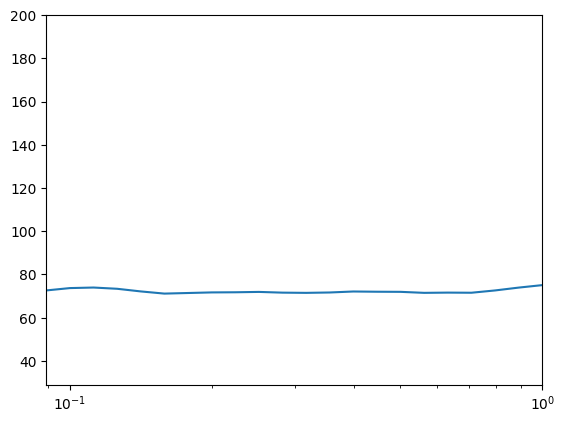

In [35]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([0.0891, 1e-0, 29, 200])

In [36]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=32, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='relu'),
  tf.keras.layers.SimpleRNN(100, activation='relu'),
  tf.keras.layers.Dense(1)
])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(dataset,epochs=200)

Epoch 1/200
4/4 [==============================] - 2s 46ms/step - loss: 230.6919 - mse: 59211.9648
Epoch 2/200
4/4 [==============================] - 0s 36ms/step - loss: 125.3820 - mse: 19584.8770
Epoch 3/200
4/4 [==============================] - 0s 40ms/step - loss: 82.5036 - mse: 10595.3623
Epoch 4/200
4/4 [==============================] - 0s 36ms/step - loss: 33.3776 - mse: 1874.7758
Epoch 5/200
4/4 [==============================] - 0s 38ms/step - loss: 42.3785 - mse: 2962.9138
Epoch 6/200
4/4 [==============================] - 0s 78ms/step - loss: 33.7969 - mse: 1932.1410
Epoch 7/200
4/4 [==============================] - 0s 86ms/step - loss: 32.9686 - mse: 1883.3375
Epoch 8/200
4/4 [==============================] - 0s 78ms/step - loss: 31.3282 - mse: 1682.3235
Epoch 9/200
4/4 [==============================] - 0s 74ms/step - loss: 29.6691 - mse: 1520.3420
Epoch 10/200
4/4 [==============================] - 0s 33ms/step - loss: 29.1499 - mse: 1513.5620
Epoch 11/200
4/4 [======

1/1 [==============================] - 0s 24ms/step


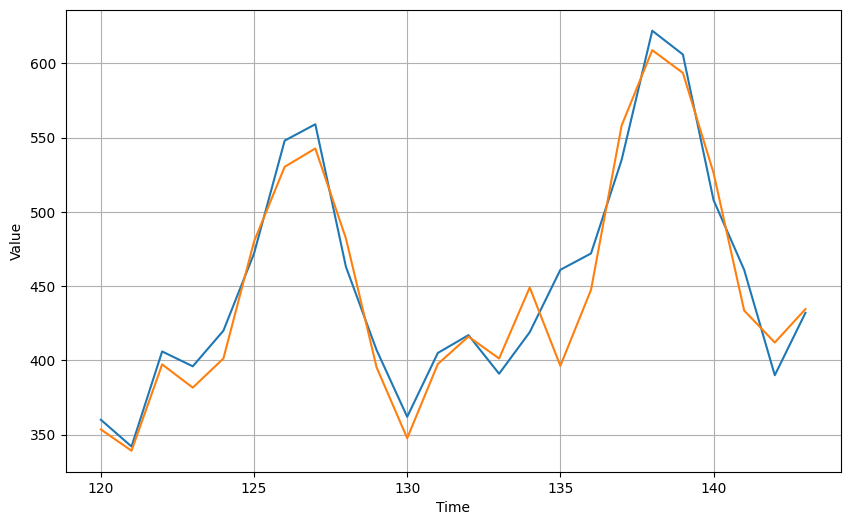

In [37]:
forecast=[] 
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

16.464973